In [278]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import numpy as np
import time
import os
import matplotlib.pyplot as plt  

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchviz import make_dot
from utils import one_hot_encode, one_hot_decode, get_all_amino_acids, get_wild_type_amino_acid_sequence
from utils import load_gfp_data, count_substring_mismatch, get_mutation

In [279]:
class VAE(nn.Module):
    # change architecture later to make it deeper if it's not good enough to capture all data
    def __init__(self, input_size, hidden_size, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_dim)
        self.fc22 = nn.Linear(hidden_size, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        
    def encode(self, x):
        # input should be one hot encoded. shape - (batch_size, alphabet x sequence_length)
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_size))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [280]:
class GenerativeVAE(): 
    
    def __init__(self, args):     
        """
        Initializes the VAE to be a generative VAE
        Parameters
        ----------
        args : dictionary
            defines the hyper-parameters of the neural network
        args.name : string 
            defines the name of the neural network
        args.description: string
            describes the architecture of the neural network
        args.input : int
            the size of the input
        args.hidden_size : int
            the size of the hidden layer
        args.latent_dim: int 
            the size of the latent dimension
        args.device : device
            the device used: cpu or gpu
        args.learning_rate : float
            sets the learning rate
        args.epochs : int 
            sets the epoch size 
        args.beta : float
            sets the beta parameter for the KL divergence loss
        args.vocabulary : string
            all the characters in the context of the problem
        """
        self.name = args["name"]
        self.description = args["description"]
        self.input = args["input"]
        self.hidden_size = args["hidden_size"]
        self.latent_dim = args["latent_dim"]
        self.device = args["device"]
        self.learning_rate = args["learning_rate"]
        self.epochs = args["epochs"]
        self.beta = args["beta"]
        self.all_characters = args["vocabulary"]
        self.num_characters = len(self.all_characters)
        self.character_to_int = dict(zip(self.all_characters, range(self.num_characters)))
        self.int_to_character = dict(zip(range(self.num_characters), self.all_characters))
        self.model = VAE(self.input, self.hidden_size, self.latent_dim)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.train_loss_history = []
        self.test_loss_history = []
        
    # Reconstruction + KL divergence losses summed over all elements in batch
    def elbo_loss(self, recon_x, x, mu, logvar):
        """
        Input: x is the one hot encoded batch_size x (seq_length * len(all_characters)) 
               recon_x is the unormalized outputs of the decoder in the same shape as x
               mu and logvar are the hidden states of size self.hidden_size
        Output: elbo_loss
        """
        # get the argmax of each batch_size x seq_length * len(all_characters) matrix. Output is in batch_size x seq_length form
        # print(labels)
        # reshapes the recon_x vector to be of shape batch_size x len(all_characters) x seq_length so that it fits according to PyTorch's CrossEntropyLoss
        # permute is transpose function so at each 1, 2 dimension we take the transpose
        # print(recon_x.shape)
        # print(reshape_x[0,:,0])
        reconstruct_x = recon_x.view(recon_x.shape[0], -1, len(self.all_characters))
        outputs = F.log_softmax(reconstruct_x, dim = 2)
        CE = (-1 * outputs * x.view(x.shape[0], -1, len(self.all_characters))).sum()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        #print("log var shape:", logvar.shape, "mu shape: ", mu.shape, "logvar: ", logvar.sum(dim=1))
        #print("mu: ", mu.sum(dim=1))
        #print((1 + logvar - mu.pow(2) - logvar.exp()).shape)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        #print("CE Loss: ", CE, "KLD Loss:", KLD, file=logger)
        return CE + KLD
    
    def NLLoss(self, recon_x, x): 
        reconstruct_x = recon_x.view(recon_x.shape[0], -1, len(self.all_characters))
        outputs = F.log_softmax(reconstruct_x, dim = 2)
        return (-1 * outputs * x.view(x.shape[0], -1, len(self.all_characters))).sum()
    
    def KLD(self, mu, logvar): 
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    def fit(self, train_dataloader, test_dataloader=None, verbose=True, logger=None, save_model=True):
        # amino acid dataset specific checks
        wild_type = get_wild_type_amino_acid_sequence()
        three_mutation = get_mutation(wild_type, num_mutations=3, alphabet=self.all_characters)
        ten_mutation = get_mutation(wild_type, num_mutations=10, alphabet=self.all_characters)
        
        if not os.path.isdir("./models/{0}".format(self.name)):
            os.mkdir("./models/{0}".format(self.name))
        
        start_time = time.time()
        self.train_loss_history, self.test_loss_history = [], []
        self.reconstruction_loss_history, self.kld_loss_history = [], []
        for epoch in range(1, self.epochs + 1):
            
            #train model
            self.model.train()
            train_loss, reconstruction_loss, kld_loss = 0, 0, 0
            for batch_idx, (x, _) in enumerate(train_dataloader):
                x = x.to(self.device)
                #labels = x.view(x.shape[0], -1, len(self.all_characters)).argmax(dim = 2)
                self.optimizer.zero_grad()
                recon_x, mu, logvar = self.model(x)
                rloss, kloss = self.NLLoss(recon_x, x), self.KLD(mu, logvar)
                loss = rloss + kloss
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                reconstruction_loss += rloss.item()
                kld_loss += kloss.item()
            self.train_loss_history.append(train_loss / len(train_dataloader.dataset))
            self.reconstruction_loss_history.append(reconstruction_loss / len(train_dataloader.dataset))
            self.kld_loss_history.append(kld_loss / len(train_dataloader.dataset))
            #evaluate model
            self.model.eval()
            decoder_outputs, _ = self.sample(num_samples=10)
            generated_sequences = [self.sample_tensor_to_string(tensor) for tensor in decoder_outputs]
            mismatches = [count_substring_mismatch(wild_type, sequence) for sequence in generated_sequences]
            wild_prob, mutation_three_prob, mutation_ten_prob = self.predict_elbo_prob([wild_type]), self.predict_elbo_prob([three_mutation]), self.predict_elbo_prob([ten_mutation])
            
            if verbose: 
                print('<====> Epoch: {0}. Average loss: {1:.4f}. Reconstruction loss: {2:.2f}. KLD loss: {3:.2f}. Time: {4:.2f} seconds'.format(
                      epoch, self.train_loss_history[-1], self.reconstruction_loss_history[-1], self.kld_loss_history[-1], time.time() - start_time), file = logger)
                print("Sample generated sequence: {0}\nAverage mismatches from the wild type: {1}".format(generated_sequences[0], np.mean(mismatches)), file = logger) 
                print("wild type elbo prob: {0}. 3 mutations elbo prob: {1}. 10 mutations elbo prob: {2}." \
                      .format(wild_prob, mutation_three_prob, mutation_ten_prob), file = logger)
            if test_dataloader:
                test_loss = self.evaluate(test_dataloader, verbose, logger)
                self.test_loss_history.append(test_loss)
            if epoch % 10 == 0 and save_model:
                self.save_model(epoch, train_loss)
                print("finished saving model", file=logger)
     
    def sample_tensor_to_string(self, x, softmax=False):
        assert(type(x) == torch.Tensor)
        assert(len(x) % self.num_characters == 0)
        x = x.reshape(-1, self.num_characters)
        if softmax:
            x = F.softmax(x, dim=1)
        string = []
        for dist in x: 
            index = torch.multinomial(dist, 1).item()
            string.append(self.int_to_character[index])
        return "".join(string)
    
    def tensor_to_string(self, x):
        """
        Input: A sequence in tensor format
        Output: A sequence in string format
        Example: tensor_to_string(torch.tensor([0, 0, 1, 0, 0, 0, 1, 0])) = "TT"
        tensor_to_string(torch.tensor([0.8, 0.15, 0.05, 0, 0, 0.9, 0.1, 0])) = "AC"
        note: alphabet is "ACTG" in this example
        """
        assert(type(x) == torch.Tensor)
        assert(len(x) % self.num_characters == 0)
        x = x.reshape(-1, self.num_characters)
        _, index = x.max(dim = 1)
        return "".join([self.int_to_character[i] for i in index.numpy()])
        
    def predict_elbo_prob(self, sequences, string=True):
        """
        Input: list of sequences in string or one_hot_encoded form
        Output: list of the elbo probability for each sequence
        Example: predict_elbo_prob(["ACT", "ACG"]) = [0.2, 0.75]
        predict_elbo_prob([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],  
                        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]]) = [0.2, 0.75]
        note: alphabet in this example is ACTG and the wild type is probably ACG***
        """
        if string: 
            sequences = one_hot_encode(sequences, self.all_characters)
        if type(sequences) != torch.Tensor:
            x = self.to_tensor(sequences)
        recon_x, mu, logvar = self.model(x)
        return self.elbo_loss(recon_x, x, mu, logvar)
    
    def evaluate(self, dataloader, verbose=True, logger=None):
        self.model.eval()
        test_loss = 0
        mismatches = []
        wild_type_mismatches, wild_type = [], get_wild_type_amino_acid_sequence()
        with torch.no_grad():
            for i, (x, _) in enumerate(dataloader):
                x = x.to(self.device)
                recon_x, mu, logvar = self.model(x)
                test_loss += self.elbo_loss(recon_x, x, mu, logvar).item()
                recon_str, x_str = self.sample_tensor_to_string(recon_x[0], softmax=True), self.tensor_to_string(x[0])
                mismatches.append(count_substring_mismatch(x_str, recon_str))
                wild_type_mismatches.append(count_substring_mismatch(wild_type, recon_str))
        test_loss /= len(dataloader.dataset)
        if verbose: 
            print('Test set loss: {0:.4f} Average Mismatches: {1:.4f} Wild Type Mismatches {2:.4f} <====> \n'.format(test_loss, np.mean(mismatches), np.mean(wild_type_mismatches)), file=logger)
        return test_loss
    
    def to_tensor(self, x): 
        assert(type(x) == np.ndarray)
        return torch.from_numpy(x).float().to(self.device)
    
    def decoder(self, z):
        """ Note that the outputs are unnormalized"""
        assert(z.shape[1] == self.latent_dim)
        if type(z) != torch.Tensor:
            z = self.to_tensor(z)
        return self.model.decode(z)
    
    def encoder(self, x, reparameterize=False): 
        assert(x.shape[1] == self.input)
        if type(x) != torch.Tensor:
            x = self.to_tensor(x)
        mu, log_var = self.model.encode(x)
        if reparameterize: 
            return self.model.reparameterize(mu, log_var), mu, log_var
        else: 
            return mu, log_var
        
    def sample(self, num_samples = 1, z = None): 
        if z is None: 
            z = torch.randn(num_samples, self.latent_dim).to(self.device)
        output = self.decoder(z)
        normalized_outputs = torch.softmax(output.view(output.shape[0], -1, self.num_characters), dim = 2)
        return normalized_outputs.view(output.shape[0], -1), z
            
    def load_model(self, model_path):
        checkpoint = torch.load(model_path)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    def save_model(self, epoch=None, loss=None): 
        torch.save({
                    'epoch': epoch,
                    'loss': loss,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict()
                }, "./models/{0}/checkpoint_{1}.pt".format(self.name, epoch))

    def show_model(self, logger=None): 
        print(self.model, file=logger)
    
    def plot_model(self, save_dir, verbose=False): 
        wild_type = get_wild_type_amino_acid_sequence()
        one_hot_wild_type = one_hot_encode([wild_type], self.all_characters)
        one_hot_tensor_wild_type = self.to_tensor(one_hot_wild_type)
        out, _, _ = self.model(one_hot_tensor_wild_type)
        graph = make_dot(out)
        if save_dir is not None:
            graph.format = "png"
            graph.render(save_dir) 
        if verbose:
            graph.view()
       
    def print_vars(self):
        print(self.__dict__)
        
    def plot_history(self, save_fig_dir): 
        plt.figure()
        plt.title("{0} Training Loss Curve".format(self.name))
        plt.plot(self.train_loss_history, label="train")
        if "test_loss_history" in self.__dict__:
            plt.plot(self.test_loss_history, label="validation")
        if "reconstruction_loss_history" in self.__dict__:
            plt.plot(self.reconstruction_loss_history, label="reconstruction_loss")
        if "kld_loss_history" in self.__dict__:
            plt.plot(self.kld_loss_history, label="kld_loss")
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel("loss")
        if save_fig_dir:
            plt.savefig(save_fig_dir)
        plt.show()


In [281]:
def get_test_args():
    args = {
        "name" : "vae_test_sample",
        "input" : 21 * 238, 
        "hidden_size" : 50,
        "latent_dim" : 20,
        "device" : torch.device("cpu"),
        "learning_rate" : 0.001,
        "epochs" : 100,
        "beta" : 1.0,
        "vocabulary" : get_all_amino_acids(),
        "num_data" : 1000, 
        "batch_size" : 10
    }
    args["description"] = "name: {0}, input size {1}, hidden size {2}, latent_dim {3}, lr {4}, epochs {5}".format(
                args["name"], args["input"], args["hidden_size"], args["latent_dim"], args["learning_rate"], args["epochs"])

    return args

In [282]:
X_train, X_test, y_train, y_test = load_gfp_data("./data/gfp_amino_acid_shuffle_")
args = get_test_args()
amino_acid_alphabet = get_all_amino_acids()
amino_acid_wild_type = get_wild_type_amino_acid_sequence()
one_hot_X_train = one_hot_encode(X_train[:args["num_data"]], amino_acid_alphabet)
one_hot_X_test = one_hot_encode(X_test[:args["num_data"]], amino_acid_alphabet)
y_train, y_test = y_train[:args["num_data"]], y_test[:args["num_data"]]
train_dataset = TensorDataset(torch.from_numpy(one_hot_X_train).float(), torch.from_numpy(y_train.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(one_hot_X_test).float(), torch.from_numpy(y_test.reshape(-1, 1)).float())
train_loader, test_loader = DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True), DataLoader(test_dataset, batch_size=args["batch_size"], shuffle=True)

In [283]:
vae = GenerativeVAE(args)
vae.print_vars()
logger = None
vae.fit(train_loader, test_loader, True, logger, "./models/{0}/".format(vae.name))

{'name': 'vae_test_sample', 'description': 'name: vae_test_sample, input size 4998, hidden size 50, latent_dim 20, lr 0.001, epochs 100', 'input': 4998, 'hidden_size': 50, 'latent_dim': 20, 'device': device(type='cpu'), 'learning_rate': 0.001, 'epochs': 100, 'beta': 1.0, 'all_characters': '*ACDEFGHIKLMNPQRSTVWY', 'num_characters': 21, 'character_to_int': {'*': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}, 'int_to_character': {0: '*', 1: 'A', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'P', 14: 'Q', 15: 'R', 16: 'S', 17: 'T', 18: 'V', 19: 'W', 20: 'Y'}, 'model': VAE(
  (fc1): Linear(in_features=4998, out_features=50, bias=True)
  (fc21): Linear(in_features=50, out_features=20, bias=True)
  (fc22): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=50, bias=True)
  (

Test set loss: 31.0020 Average Mismatches: 6.6800 Wild Type Mismatches 2.6700 <====> 

<====> Epoch: 13. Average loss: 28.0871. Reconstruction loss: 24.62. KLD loss: 3.47. Time: 29.64 seconds
Sample generated sequence: YKGEVAFSRVVPFWVELEGDVNGHKFSVSGGGIGDATYGKRTLKFVCTTGKLKVPWPTLVTTLSYCVQSFSRYSGHMKQHDFFKGAMPQGNAQWRTIFSKDNGWYKARAESWFEGDYLVNRIDLNGIDFREDGN*LGHKLEVSYNSRNVKIMADKLKNGIKAIFMPRHDLEDGSAPLADHKQ*NTPLACGPV*QPDNHHQCTQAAPSKRPNEKRDHLALLEFNAA*GITHGMVELYN*
Average mismatches from the wild type: 71.0
wild type elbo prob: 5.109663963317871. 3 mutations elbo prob: 40.87541961669922. 10 mutations elbo prob: 122.96958923339844.
Test set loss: 30.3502 Average Mismatches: 7.8100 Wild Type Mismatches 4.1200 <====> 

<====> Epoch: 14. Average loss: 27.8695. Reconstruction loss: 24.72. KLD loss: 3.15. Time: 31.98 seconds
Sample generated sequence: SKGEELFSGVVPILVELDGDVNGHKFSVSGEGEGDATQGKLTLKFNCTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMRQHDFFISAMPEGYVQERTIFFRDDGNYKTRAEVKFEGDTLVDRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMA

<====> Epoch: 26. Average loss: 23.2950. Reconstruction loss: 23.21. KLD loss: 0.09. Time: 65.47 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNIPGHKLEYNYNSHNIYIMADKQKNGIKVNFKIRHNIEDGGVQLADHYQQNTPIGRGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.2
wild type elbo prob: 4.57969856262207. 3 mutations elbo prob: 39.16936111450195. 10 mutations elbo prob: 146.89529418945312.
Test set loss: 25.4433 Average Mismatches: 7.3400 Wild Type Mismatches 3.6000 <====> 

<====> Epoch: 27. Average loss: 23.1463. Reconstruction loss: 23.08. KLD loss: 0.06. Time: 67.74 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVPLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Ave

Test set loss: 25.5878 Average Mismatches: 7.0800 Wild Type Mismatches 3.5000 <====> 

<====> Epoch: 40. Average loss: 22.9139. Reconstruction loss: 22.91. KLD loss: 0.01. Time: 101.15 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFRSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.8
wild type elbo prob: 3.106877326965332. 3 mutations elbo prob: 35.04255676269531. 10 mutations elbo prob: 129.9385528564453.
Test set loss: 25.5685 Average Mismatches: 7.3700 Wild Type Mismatches 3.7300 <====> 

finished saving model
<====> Epoch: 41. Average loss: 22.8936. Reconstruction loss: 22.89. KLD loss: 0.01. Time: 103.68 seconds
Sample generated sequence: SKGEELSTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGAQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGDYKTRAEVKFEGGTLVNRIELKGIDFKE

Test set loss: 25.7076 Average Mismatches: 7.3100 Wild Type Mismatches 3.8000 <====> 

<====> Epoch: 53. Average loss: 22.8611. Reconstruction loss: 22.85. KLD loss: 0.01. Time: 134.54 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFTCTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSALPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELRGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVSFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVAAAGTTHGMDELYK*
Average mismatches from the wild type: 4.2
wild type elbo prob: 3.5165724754333496. 3 mutations elbo prob: 35.471012115478516. 10 mutations elbo prob: 118.9201889038086.
Test set loss: 25.7236 Average Mismatches: 7.6800 Wild Type Mismatches 3.8300 <====> 

<====> Epoch: 54. Average loss: 22.8257. Reconstruction loss: 22.82. KLD loss: 0.01. Time: 137.45 seconds
Sample generated sequence: SEGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYI

Test set loss: 25.8051 Average Mismatches: 7.7400 Wild Type Mismatches 3.8300 <====> 

<====> Epoch: 66. Average loss: 22.7573. Reconstruction loss: 22.73. KLD loss: 0.02. Time: 170.60 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEG*VQERTIFFKDDGNYKTRAEVKFEGDTLVDRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.8
wild type elbo prob: 3.3349151611328125. 3 mutations elbo prob: 36.19539260864258. 10 mutations elbo prob: 127.01129150390625.
Test set loss: 25.8131 Average Mismatches: 7.2000 Wild Type Mismatches 3.6000 <====> 

<====> Epoch: 67. Average loss: 22.7635. Reconstruction loss: 22.74. KLD loss: 0.02. Time: 173.05 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFIKDDGNYKTRAEVKFEGDTLVNRIELKGIDFEEDGNILGHKLEYNYNSHNVYI

<====> Epoch: 79. Average loss: 22.7379. Reconstruction loss: 22.68. KLD loss: 0.06. Time: 200.95 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEGGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 4.1
wild type elbo prob: 3.272245407104492. 3 mutations elbo prob: 38.81349182128906. 10 mutations elbo prob: 123.59123229980469.
Test set loss: 25.9361 Average Mismatches: 7.2000 Wild Type Mismatches 3.5100 <====> 

<====> Epoch: 80. Average loss: 22.7368. Reconstruction loss: 22.68. KLD loss: 0.06. Time: 203.24 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGMLTLKFICTTGKLPVPWPTLVATLSYGVQCFSRYPVHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLECNYNSHNVYIMADKQKNGIKVNFEIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*


<====> Epoch: 92. Average loss: 22.6591. Reconstruction loss: 22.52. KLD loss: 0.13. Time: 234.02 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFEDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHELEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.0
wild type elbo prob: 2.647733688354492. 3 mutations elbo prob: 42.00072479248047. 10 mutations elbo prob: 133.04432678222656.
Test set loss: 26.1169 Average Mismatches: 7.2300 Wild Type Mismatches 3.7400 <====> 

<====> Epoch: 93. Average loss: 22.6339. Reconstruction loss: 22.48. KLD loss: 0.15. Time: 236.10 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGVVNGHKFSVSGEGEGDAAYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*


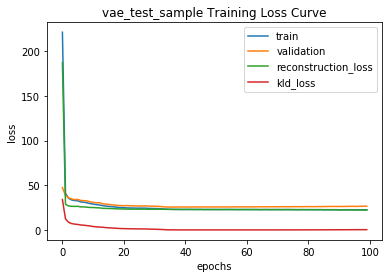

VAE(
  (fc1): Linear(in_features=4998, out_features=50, bias=True)
  (fc21): Linear(in_features=50, out_features=20, bias=True)
  (fc22): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=4998, bias=True)
)


AssertionError: 

In [277]:
vae.plot_model("./logs/vae/{0}_model_architecture".format(vae.name))
vae.plot_history("./logs/vae/{0}_training_history".format(vae.name))
vae.show_model(None)
load_vae = GenerativeVAE(args)
load_vae.load_model("./models/{0}/checkpoint_30.pt".format(vae.name))
for parameter_name, load_weights in load_vae.model.state_dict().items():
    vae_weights = vae.model.state_dict()[parameter_name]
    assert(torch.all(torch.eq(load_weights, vae_weights)).item())

for (x, _) in test_loader:         
    x = x.to(load_vae.device)
    z, z_mean, z_var = load_vae.encoder(x, reparameterize=True)
    z_mean_2, z_var_2 = vae.encoder(x)
    assert(torch.all(torch.eq(z_mean, z_mean_2)).item())
    assert(torch.all(torch.eq(z_var, z_var_2)).item())
    recon_x = load_vae.decoder(z)
    recon_x_2 = vae.decoder(z)
    loss_1 = vae.elbo_loss(recon_x, x, z_mean, z_var).item()
    loss_2 = vae.elbo_loss(recon_x_2, x, z_mean, z_var).item()
    np.testing.assert_equal(loss_1, loss_2)

In [228]:
if logger:
    logger.close()

In [ ]:
model = VAE(784, 400, 20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'logs/vae/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    
"""
parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
"""
class Args:
    def __init__(self):
        self.batch_size = 128
        self.epochs = 2
        self.no_cuda = True
        self.seed = 1
        self.log_interval = 10
        

args = Args()

args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)

train(1)

In [33]:
def string_to_index(string, alphabet):
    return np.array([alphabet.index(s) for s in string])

wild_type_index = string_to_index(get_wild_type_amino_acid_sequence(), alphabet = get_all_amino_acids())
wild_type_index_tensor = torch.from_numpy(wild_type_index)

In [52]:
normalized_prob = np.random.randint(0, 21, 21)
normalized_prob = normalized_prob / normalized_prob.sum()
x = torch.tensor([[0] * 15 + [1] + [0] * 5, normalized_prob])
wild_type_probs = []
for probs, index in zip(x, wild_type_index):
    wild_type_probs.append(probs[index])

sums = x.sum(dim = 1)
print(x, sums)
sums = sums - torch.tensor(wild_type_probs)
print(sums)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0822, 0.0137, 0.0320, 0.0091, 0.0639, 0.0776, 0.0046, 0.0502, 0.0776,
         0.0913, 0.0594, 0.0137, 0.0000, 0.0868, 0.0228, 0.0320, 0.0411, 0.0548,
         0.0411, 0.0776, 0.0685]], dtype=torch.float64) tensor([1.0000, 1.0000], dtype=torch.float64)
tensor([1.0000, 0.9087], dtype=torch.float64)


In [55]:
loss = nn.CrossEntropyLoss()
input = torch.randn(2, 3, 4, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

In [60]:
torch.empty(3, dtype=torch.long).random_(5)

tensor([0, 4, 2])

In [66]:
x = torch.randn(3, 5)
print(x)
x.argmax(dim = 1)

tensor([[-1.4653, -1.0134,  0.0671, -2.0208, -0.0811],
        [-0.5681,  1.4572,  1.2459, -0.1435,  0.7575],
        [ 0.2731, -2.1939,  0.1123, -0.6824,  0.4075]])


tensor([2, 1, 4])

In [63]:
length = 10
wild_type = get_wild_type_amino_acid_sequence()
one_hot = one_hot_encode([wild_type[0:length], wild_type[0:length]], get_all_amino_acids())
for i in range(one_hot.shape[0]): 
    for j in range(one_hot.shape[1]): 
        if not one_hot[i, j]:
            one_hot[i, j] = eps
        else:
            one_hot[i, j] = 1
            
one_hot_tensor = torch.from_numpy(one_hot)
print(one_hot_tensor.shape)
labels = one_hot_tensor.view(2, length, len(get_all_amino_acids())).argmax(dim = 2).float()
print(labels.shape)
print(one_hot_tensor.view(2, length, len(get_all_amino_acids()))[0][0])
print(one_hot_tensor.view(2, length, len(get_all_amino_acids())).permute(0, 2, 1).shape)
print(one_hot_tensor.view(2, length, len(get_all_amino_acids())).permute(0, 2, 1)[0, :, 0])
print(one_hot_tensor.view(2, length, len(get_all_amino_acids())).permute(0, 2, 1)[0, 16])
x = one_hot_tensor.view(2, length, len(get_all_amino_acids())).permute(0, 2, 1)
z = nn.CrossEntropyLoss(reduction='sum')(x, labels).item()
print(z)

torch.Size([2, 210])
torch.Size([2, 10])
tensor([-1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08,  1.0000e+00, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08], dtype=torch.float64)
torch.Size([2, 21, 10])
tensor([-1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08,  1.0000e+00, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08], dtype=torch.float64)
tensor([ 1.0000e+00, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08],
       dtype=torch.float64)


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target'

In [46]:
eps = -1e8
x = torch.tensor(np.array([[1, eps, eps], [eps, 1, eps]])).float()
labels = torch.tensor(np.array([0, 1]))
print(torch.all(torch.eq(x.argmax(1), labels)).item() == 1)
F.cross_entropy(x, labels, reduction='sum')

True


tensor(0.)

In [32]:
[x if x else eps for x in one_hot[0]]

(2, 63)

In [175]:
x = torch.randn(3, 3, 5)


tensor([[[-2.1489, -1.4456, -3.2613, -3.3038, -0.5574],
         [-2.2018, -1.3564, -1.8980, -0.8716, -2.7541],
         [-1.0349, -1.3823, -1.8581, -3.3522, -1.5958]],

        [[-1.8522, -3.5563, -0.7642, -3.0691, -1.1961],
         [-2.2367, -2.4859, -0.9454, -2.5285, -1.0740],
         [-1.3448, -2.4309, -1.0460, -2.8123, -1.4270]],

        [[-3.8434, -0.5309, -2.8926, -2.6222, -1.3378],
         [-2.8145, -2.0604, -0.9137, -1.0996, -2.5432],
         [-0.4621, -2.3404, -2.8733, -2.2319, -2.2081]]])

In [179]:
z = F.log_softmax(x, dim=2)
z

tensor([[[-2.1489, -1.4456, -3.2613, -3.3038, -0.5574],
         [-2.2018, -1.3564, -1.8980, -0.8716, -2.7541],
         [-1.0349, -1.3823, -1.8581, -3.3522, -1.5958]],

        [[-1.8522, -3.5563, -0.7642, -3.0691, -1.1961],
         [-2.2367, -2.4859, -0.9454, -2.5285, -1.0740],
         [-1.3448, -2.4309, -1.0460, -2.8123, -1.4270]],

        [[-3.8434, -0.5309, -2.8926, -2.6222, -1.3378],
         [-2.8145, -2.0604, -0.9137, -1.0996, -2.5432],
         [-0.4621, -2.3404, -2.8733, -2.2319, -2.2081]]])

In [186]:
x = torch.zeros(3, 3, 5)
x[:, :, 4] = 1
x

tensor([[[0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.]]])

In [188]:
-(z * x).sum()

tensor(14.6936)